In [1]:
import sys
import logging
import pickle
import yaml
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
from joblib import hash, dump, load
import os

from deer.default_parser import process_args
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR
from simple_maze_env import MyEnv as simple_maze_env
import deer.experiment.base_controllers as bc

from deer.policies import EpsilonGreedyPolicy, FixedFigure8Policy

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
nn_yaml = 'network_simpler.yaml'
internal_dim = 5
fname = 'foraging_test'
set_network = None #['foraging_mb', 30, True]

In [3]:
parameters = {
    'nn_yaml': nn_yaml,
    'higher_dim_obs': True,
    'internal_dim': internal_dim,
    'fname': fname,
    'steps_per_epoch': 1000,
    'epochs': 40,
    'steps_per_test': 1000,
    'period_btw_summary_perfs': 1,
    'encoder_type': 'regular',
    'frame_skip': 2,
    'learning_rate': 1*1E-4,
    'learning_rate_decay': 1.0,
    'discount': 0.9,
    'epsilon_start': 1.0,
    'epsilon_min': 1.0,
    'epsilon_decay': 1000,
    'update_frequency': 1,
    'replay_memory_size': 100000, #50000
    'batch_size': 64,
    'freeze_interval': 1000,
    'deterministic': False,
    #'loss_weights': [0, 1E-3, 1E-3, 0, 0, 1E-2, 1., 0],
    #'loss_weights': [0, 0, 0, 0, 0, 0, 1., 0.],
    'loss_weights': [1E-2, 1E-3, 1E-3, 0, 0, 1E-2, 1., 0],
    'foraging_give_rewards': True
    }

In [4]:
rng = np.random.RandomState()
env = simple_maze_env(
    rng, reward=parameters['foraging_give_rewards'],
    higher_dim_obs=parameters['higher_dim_obs'], plotfig=False
    )

# Algorithm
learning_algo = CRAR(
    env, parameters['freeze_interval'], parameters['batch_size'], rng,
    high_int_dim=False, internal_dim=parameters['internal_dim'],
    lr=parameters['learning_rate'], nn_yaml=parameters['nn_yaml'],
    double_Q=True, loss_weights=parameters['loss_weights'],
    encoder_type=parameters['encoder_type']
    )

# Policies
train_policy = EpsilonGreedyPolicy(learning_algo, env.nActions(), rng, 0.2)
test_policy = EpsilonGreedyPolicy(learning_algo, env.nActions(), rng, 0.)

# Initialize Agent
agent = NeuralAgent(
    env, learning_algo, parameters['replay_memory_size'], 1,
    parameters['batch_size'], rng,
    train_policy=train_policy, test_policy=test_policy)
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )
agent.run(10, 500)

# Attach controllers
agent.attach(bc.VerboseController( evaluate_on='epoch', periodicity=1))
agent.attach(bc.LearningRateController(
    initial_learning_rate=parameters['learning_rate'],
    learning_rate_decay=parameters['learning_rate_decay'],
    periodicity=1))
agent.attach(bc.TrainerController(
    evaluate_on='action', periodicity=parameters['update_frequency'],
    show_episode_avg_V_value=True, show_avg_Bellman_residual=True))
best_controller = bc.FindBestController(
    validationID=simple_maze_env.VALIDATION_MODE,
    testID=None, unique_fname=fname, savefrequency=5)
agent.attach(best_controller)
agent.attach(bc.InterleavedTestEpochController(
    id=simple_maze_env.VALIDATION_MODE, epoch_length=parameters['steps_per_test'],
    periodicity=1, show_score=True, summarize_every=1, unique_fname=fname))

In [5]:
agent._learning_algo.device

device(type='cuda', index=0)

In [6]:
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )
agent.run(parameters['epochs'], parameters['steps_per_epoch'])

Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.0807, -0.0857, -0.0057, -0.1554,  0.1192], device='cuda:0') tensor([ 0.3330, -0.1851, -0.3336,  0.0647,  0.0738], device='cuda:0') tensor([ 0.0807, -0.0857, -0.0057, -0.1554,  0.1192], device='cuda:0')
R[0]
tensor([-0.0546], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.003415740124904358
Episode average V value: 0.15570264694591363
Average (on the epoch) training loss: 0.00336809992131748
Episode average V value: 0.12012501060962677
LOSSES
T = 0.1447041718661785; R = 0.0017219588218722493;                 Gamma = 0.5316034160256385; Q = 0.0038452901601121994;
Entropy Neighbor = 0.9753812888860702;                 Entropy Random = 0.8842864360809326;                 Volume = 0.0; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], 

/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Testing score per episode (id: 0) is 0.0 (average over 1 episode(s))
== Mean score per episode is 0.0 over 1 episodes ==


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:125: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  torch.tensor(all_possib_inp).float().to(device)
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.2121, -0.0374,  0.3912, -0.2887, -0.3220], device='cuda:0') tensor([ 0.1794, -0.0789,  0.0722, -0.2562, -0.1784], device='cuda:0') tensor([ 0.2121, -0.0374,  0.3912, -0.2887, -0.3220], device='cuda:0')
R[0]
tensor([-0.0226], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0011157518253201782
Episode average V value: 0.022620867830248956
Average (on the epoch) training loss: 0.001068353596645011
Episode average V value: 0.023358764592558146
LOSSES
T = 0.019412142321467398; R = 0.0006311563738136101;                 Gamma = 0.5297325732707977; Q = 0.000994754245310105;
Entropy Neighbor = 0.9396863489151001;                 Entropy Random = 0.7070710716247559;                 Volume = 0.0; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.1832, -0.0626,  0.2608, -0.2436, -0.1876], device='cuda:0') tensor([ 0.1462, -0.1366,  0.1215, -0.2559, -0.1791], device='cuda:0') tensor([ 0.1832, -0.0626,  0.2608, -0.2436, -0.1876], device='cuda:0')
R[0]
tensor([0.0029], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0006158487173380509
Episode average V value: 0.025879337900240003
Average (on the epoch) training loss: 0.0006796388617871383
Episode average V value: 0.020292935860261582
Average (on the epoch) training loss: 0.0009785544291870403
Episode average V value: 0.020118787010878693
Average (on the epoch) training loss: 0.0009706661870739213
Episode average V value: 0.03069954179227352
Average (on the epoch) training loss: 0.0010011748847656358
Episode average V value: 0.026308803579636983
Average (on the epoch) training loss: 0.0009545004666987926
Ep

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.1191, -0.1208,  0.2249, -0.2505, -0.1828], device='cuda:0') tensor([ 0.1209, -0.1446,  0.2149, -0.2637, -0.1964], device='cuda:0') tensor([ 0.1191, -0.1208,  0.2249, -0.2505, -0.1828], device='cuda:0')
R[0]
tensor([0.0054], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0021708169560544993
Episode average V value: 0.024980076911611172
Average (on the epoch) training loss: 0.0022680880620787065
Episode average V value: 0.04467085985974832
Average (on the epoch) training loss: 0.0022381280033292824
Episode average V value: 0.04159701863924662
Average (on the epoch) training loss: 0.00219921362372692
Episode average V value: 0.03469030745327473
LOSSES
T = 0.006762711969204247; R = 0.002021521997558011;                 Gamma = 0.5265376247167587; Q = 0.00195788349997747;
Entropy Neighbor = 0.8581308038234711;      

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.1758, -0.0704,  0.2349, -0.2444, -0.1852], device='cuda:0') tensor([ 0.0893, -0.1581,  0.1538, -0.2055, -0.2060], device='cuda:0') tensor([-0.0306, -0.2458,  0.1762, -0.2616, -0.1690], device='cuda:0')
R[0]
tensor([0.0017], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.001095410440289665
Episode average V value: 0.02853213709134322
LOSSES
T = 0.009220626018941403; R = 0.0020673516713577557;                 Gamma = 0.5279184619188309; Q = 0.0019480241778146593;
Entropy Neighbor = 0.8187795532941818;                 Entropy Random = 0.3761663890480995;                 Volume = 0.0; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.0514, -0.1750,  0.2092, -0.2628, -0.2010], device='cuda:0') tensor([ 0.0600, -0.142

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.0988, -0.1313,  0.1964, -0.2461, -0.1697], device='cuda:0') tensor([ 0.0889, -0.1470,  0.1721, -0.2210, -0.2104], device='cuda:0') tensor([ 0.2668,  0.0172,  0.2055, -0.2107, -0.1273], device='cuda:0')
R[0]
tensor([0.0018], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.002367636465525521
Episode average V value: 0.037427869357474865
Average (on the epoch) training loss: 0.0023829565880639425
Episode average V value: 0.04597703693434596
Average (on the epoch) training loss: 0.0023690438686744695
Episode average V value: 0.11223797500133514
Average (on the epoch) training loss: 0.002401662538939617
Episode average V value: 0.05678929481655359
Average (on the epoch) training loss: 0.0023253679093736385
Episode average V value: 0.061991965770721434
Average (on the epoch) training loss: 0.0023128674653976277
Episod

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.0741, -0.1595,  0.2174, -0.2862, -0.2450], device='cuda:0') tensor([ 0.0831, -0.1202,  0.1956, -0.2748, -0.1843], device='cuda:0') tensor([ 0.0741, -0.1595,  0.2174, -0.2862, -0.2450], device='cuda:0')
R[0]
tensor([-0.0037], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0027500419959583917
Episode average V value: 0.03304612583347729
Average (on the epoch) training loss: 0.0035596128685651102
Episode average V value: 0.06202330546719687
Average (on the epoch) training loss: 0.0034463696471085945
Episode average V value: 0.14308108389377594
Average (on the epoch) training loss: 0.003442948034457264
Episode average V value: 0.06410240568220615
Average (on the epoch) training loss: 0.0033151990859735542
Episode average V value: 0.06817193577686946
Average (on the epoch) training loss: 0.003184468188717599
Episode

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.0490, -0.2259,  0.1527, -0.3191, -0.2520], device='cuda:0') tensor([ 0.0977, -0.1057,  0.2205, -0.2998, -0.2354], device='cuda:0') tensor([-0.0490, -0.2259,  0.1527, -0.3191, -0.2520], device='cuda:0')
R[0]
tensor([0.0104], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0034953727528253303
Episode average V value: 0.08340725196259362
Average (on the epoch) training loss: 0.0039864106929599075
Episode average V value: 0.244130939245224
Average (on the epoch) training loss: 0.00587994579756115
Episode average V value: 0.11910569444298744
Average (on the epoch) training loss: 0.005927880249253255
Episode average V value: 0.13369435320297876
Average (on the epoch) training loss: 0.004904226583780603
Episode average V value: 0.0592288852862592
Average (on the epoch) training loss: 0.005674636976227003
Episode averag

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.3219,  0.0926,  0.2542, -0.2965, -0.2895], device='cuda:0') tensor([ 0.2729,  0.0405,  0.2366, -0.2984, -0.2412], device='cuda:0') tensor([ 0.3219,  0.0926,  0.2542, -0.2965, -0.2895], device='cuda:0')
R[0]
tensor([0.0007], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.005584765070428451
Episode average V value: 0.2212674253516727
Average (on the epoch) training loss: 0.005163016135338694
Episode average V value: 0.6014223694801331
Average (on the epoch) training loss: 0.0056870227453072325
Episode average V value: 0.1408503269776702
Average (on the epoch) training loss: 0.005637331197871582
Episode average V value: 0.450775682926178
Average (on the epoch) training loss: 0.005809006484923884
Episode average V value: 0.4918360114097595
Average (on the epoch) training loss: 0.004847290117042855
Episode average V

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.3556,  0.1446,  0.2702, -0.3277, -0.3359], device='cuda:0') tensor([ 0.3033,  0.0855,  0.2524, -0.3289, -0.3027], device='cuda:0') tensor([ 0.3556,  0.1446,  0.2702, -0.3277, -0.3359], device='cuda:0')
R[0]
tensor([-0.0008], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.005496015859534964
Episode average V value: 0.17641893308609724
Average (on the epoch) training loss: 0.004465419256073227
Episode average V value: 0.08948791322900969
Average (on the epoch) training loss: 0.004565976330518929
Episode average V value: 0.1596349959190075
Average (on the epoch) training loss: 0.004674011689325374
Episode average V value: 0.5410306503375372
Average (on the epoch) training loss: 0.004667867327113457
Episode average V value: 0.28856719827110117
Average (on the epoch) training loss: 0.004440884339638297
Episode avera

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.3837,  0.1974,  0.2983, -0.3655, -0.4116], device='cuda:0') tensor([ 0.3315,  0.1351,  0.2788, -0.3614, -0.3663], device='cuda:0') tensor([ 0.3837,  0.1974,  0.2983, -0.3655, -0.4116], device='cuda:0')
R[0]
tensor([-0.0010], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0022602766153535674
Episode average V value: 0.2529403418302536
Average (on the epoch) training loss: 0.002423216309398413
Episode average V value: 0.23980329930782318
Average (on the epoch) training loss: 0.0043180729809267045
Episode average V value: 0.09773928717924998
Average (on the epoch) training loss: 0.004270644037594163
Episode average V value: 0.1763679965637451
Average (on the epoch) training loss: 0.004306196043906725
Episode average V value: 0.19326168447732925
LOSSES
T = 0.014930966480635107; R = 0.007028455542109441;            

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.1996,  0.0374,  0.2222, -0.3796, -0.3758], device='cuda:0') tensor([ 0.2282,  0.0653,  0.2337, -0.3863, -0.4160], device='cuda:0') tensor([ 0.1996,  0.0374,  0.2222, -0.3796, -0.3758], device='cuda:0')
R[0]
tensor([0.0052], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0034198850167180914
Episode average V value: 0.19057122349739075
Average (on the epoch) training loss: 0.003979669357161789
Episode average V value: 0.4192718416452408
Average (on the epoch) training loss: 0.0040865955500824684
Episode average V value: 0.189978585961987
Average (on the epoch) training loss: 0.004166900009671548
Episode average V value: 0.3179785318672657
Average (on the epoch) training loss: 0.0046421720094213465
Episode average V value: 0.2053858641357649
LOSSES
T = 0.013573902087751775; R = 0.0074721220431092665;              

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.2121,  0.0551,  0.2564, -0.4254, -0.4695], device='cuda:0') tensor([ 0.2871,  0.1443,  0.2820, -0.4123, -0.4579], device='cuda:0') tensor([ 0.5229,  0.3466,  0.3620, -0.3810, -0.4694], device='cuda:0')
R[0]
tensor([0.0070], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.005551512265064491
Episode average V value: 0.15840109456808138
LOSSES
T = 0.01309868018887937; R = 0.007231193540035747;                 Gamma = 0.5526385610103607; Q = 0.004069116991915507;
Entropy Neighbor = 0.6488736245632172;                 Entropy Random = 0.2403759893476963;                 Volume = 0.02349916346743703; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.5268,  0.3546,  0.3531, -0.3712, -0.4533], device='cuda:0') tensor([ 0

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.6311,  0.4615,  0.4058, -0.3826, -0.4979], device='cuda:0') tensor([ 0.6428,  0.4662,  0.4290, -0.3869, -0.4859], device='cuda:0') tensor([ 0.6311,  0.4615,  0.4058, -0.3826, -0.4979], device='cuda:0')
R[0]
tensor([0.0036], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.003519433899782598
Episode average V value: 0.3299292163415389
Average (on the epoch) training loss: 0.0034179640157769122
Episode average V value: 0.5725761502981186
Average (on the epoch) training loss: 0.004235986742871598
Episode average V value: 0.17743254616856574
Average (on the epoch) training loss: 0.0036528669936434096
Episode average V value: 0.12216611734280984
Average (on the epoch) training loss: 0.003751452841243008
Episode average V value: 0.2366066469300178
Average (on the epoch) training loss: 0.0037309419167035358
Episode aver

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.6998,  0.5387,  0.4389, -0.3943, -0.5325], device='cuda:0') tensor([ 0.6820,  0.4968,  0.4288, -0.3899, -0.5314], device='cuda:0') tensor([ 0.6998,  0.5387,  0.4389, -0.3943, -0.5325], device='cuda:0')
R[0]
tensor([-0.0006], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.004402882842368436
Episode average V value: 0.16711335809066377
Average (on the epoch) training loss: 0.004108767813733338
Episode average V value: 0.14785977800204916
Average (on the epoch) training loss: 0.0039993085175197805
Episode average V value: 0.2066078581089197
Average (on the epoch) training loss: 0.003971252086097902
Episode average V value: 0.19702201721997098
Average (on the epoch) training loss: 0.003980745264323823
Episode average V value: 0.7038738876581192
Average (on the epoch) training loss: 0.003967672195311333
Episode aver

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.5823,  0.4370,  0.4061, -0.4346, -0.5698], device='cuda:0') tensor([ 0.5737,  0.4075,  0.3976, -0.4342, -0.5715], device='cuda:0') tensor([ 0.5823,  0.4370,  0.4061, -0.4346, -0.5698], device='cuda:0')
R[0]
tensor([0.0015], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0008299458713736385
Episode average V value: 0.9413624703884125
Average (on the epoch) training loss: 0.004509419654452897
Episode average V value: 0.28221026472016875
Average (on the epoch) training loss: 0.003918095875997096
Episode average V value: 0.22622597457901125
Average (on the epoch) training loss: 0.0038775328857616146
Episode average V value: 0.4400127132733663
Average (on the epoch) training loss: 0.003945841426438828
Episode average V value: 0.19187696292152945
Average (on the epoch) training loss: 0.0039170050073880705
Episode ave

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.3683,  0.2337,  0.3298, -0.4725, -0.5809], device='cuda:0') tensor([ 0.4655,  0.3349,  0.3737, -0.4700, -0.5910], device='cuda:0') tensor([ 0.5168,  0.3745,  0.3742, -0.4374, -0.5500], device='cuda:0')
R[0]
tensor([-0.0087], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.003761881835392463
Episode average V value: 0.17491270131186434
Average (on the epoch) training loss: 0.00375297127495287
Episode average V value: 0.8847726881504059
Average (on the epoch) training loss: 0.0037019408412631424
Episode average V value: 0.8702238351106644
Average (on the epoch) training loss: 0.003634662247488358
Episode average V value: 0.20020317838147836
Average (on the epoch) training loss: 0.003760334882091239
Episode average V value: 0.19661456644535064
Average (on the epoch) training loss: 0.003802745348404537
Episode avera

Average (on the epoch) training loss: 0.003869470584741206
Episode average V value: 0.6134549230337143
Average (on the epoch) training loss: 0.0038947338980506174
Episode average V value: 0.41993216921885806
Average (on the epoch) training loss: 0.0038805295204451845
Episode average V value: 0.3522790792313489
Average (on the epoch) training loss: 0.0038768326552777203
Episode average V value: 0.30455300956964493
Average (on the epoch) training loss: 0.0038742392009296646
Episode average V value: 0.5670344233512878
Average (on the epoch) training loss: 0.0038739447534214396
Episode average V value: 0.5273059085011482
Average (on the epoch) training loss: 0.003872333149017516
Episode average V value: 0.30401166155934334
Average (on the epoch) training loss: 0.0038592492848574618
Episode average V value: 0.40618630312383175
Average (on the epoch) training loss: 0.0038635901576145122
Episode average V value: 0.5993259698152542
LOSSES
T = 0.01458141648583114; R = 0.007846260443970096;     

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.5226,  0.3938,  0.3935, -0.4757, -0.6132], device='cuda:0') tensor([ 0.5233,  0.3763,  0.3892, -0.4789, -0.6262], device='cuda:0') tensor([ 0.6898,  0.5643,  0.4738, -0.4841, -0.6654], device='cuda:0')
R[0]
tensor([0.0001], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0053495539098300715
Episode average V value: 0.30504013056104834
Average (on the epoch) training loss: 0.005192289788586398
Episode average V value: 0
Average (on the epoch) training loss: 0.004192244514877743
Episode average V value: 0.633566927909851
Average (on the epoch) training loss: 0.004074214738793671
Episode average V value: 0.37768677165431364
Average (on the epoch) training loss: 0.003948618023423478
Episode average V value: 0.5771826148033142
Average (on the epoch) training loss: 0.003934066453384179
Episode average V value: 0.51794

Average (on the epoch) training loss: 0.004362412506610259
Episode average V value: 0.5492376652028825
Average (on the epoch) training loss: 0.004358448242524789
Episode average V value: 0.5018601218859354
Average (on the epoch) training loss: 0.004355140313976272
Episode average V value: 0.4555214014318254
Average (on the epoch) training loss: 0.0043517330378897885
Episode average V value: 0.8885000646114349
Average (on the epoch) training loss: 0.00434756470615772
Episode average V value: 0.6600697636604309
Average (on the epoch) training loss: 0.004353488475749176
Episode average V value: 0.5058608220683204
Average (on the epoch) training loss: 0.004342648153470074
Episode average V value: 0.7515333394209543
Average (on the epoch) training loss: 0.004330447420353126
Episode average V value: 0.31179367479952896
Average (on the epoch) training loss: 0.004329323248117875
Episode average V value: 0.58638896048069
Average (on the epoch) training loss: 0.004332160029816501
Episode average

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.3537,  0.2412,  0.3385, -0.5231, -0.6604], device='cuda:0') tensor([ 0.3538,  0.2363,  0.3423, -0.5255, -0.6734], device='cuda:0') tensor([ 0.3537,  0.2412,  0.3385, -0.5231, -0.6604], device='cuda:0')
R[0]
tensor([-0.0008], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.006650151817926339
Episode average V value: 0.637269934018453
Average (on the epoch) training loss: 0.005579737775648633
Episode average V value: 0.5917459626992544
Average (on the epoch) training loss: 0.004958319497983093
Episode average V value: 0.6562777757644653
Average (on the epoch) training loss: 0.004764812655943947
Episode average V value: 0.41946365607195885
Average (on the epoch) training loss: 0.004690667813305151
Episode average V value: 0.5037640929222107
Average (on the epoch) training loss: 0.00436958155395197
Episode average V

Average (on the epoch) training loss: 0.004482810047085139
Episode average V value: 0.6712539196014404
Average (on the epoch) training loss: 0.004489553824575841
Episode average V value: 0.93736132979393
Average (on the epoch) training loss: 0.004486758774314344
Episode average V value: 0.2890008375758216
Average (on the epoch) training loss: 0.004463326033837504
Episode average V value: 0.3717188693228222
Average (on the epoch) training loss: 0.00446419492594053
Episode average V value: 0.5113744458981923
Average (on the epoch) training loss: 0.004473329968444332
Episode average V value: 0.5478407690922419
Average (on the epoch) training loss: 0.004477552839845617
Episode average V value: 1.0621429681777954
Average (on the epoch) training loss: 0.0044914789961135095
Episode average V value: 0.4141229081612367
Average (on the epoch) training loss: 0.00449957288337582
Episode average V value: 0.46584078669548035
Average (on the epoch) training loss: 0.004491784104953279
Episode average 

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.2560, -0.3610,  0.0890, -0.5760, -0.6255], device='cuda:0') tensor([-0.2115, -0.3316,  0.0853, -0.6040, -0.7391], device='cuda:0') tensor([-0.3456, -0.4376,  0.0808, -0.6314, -0.7075], device='cuda:0')
R[0]
tensor([0.0166], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0032453968500097594
Episode average V value: 0.9046541651089987
Average (on the epoch) training loss: 0.005634914897382259
Episode average V value: 0.9406766295433044
Average (on the epoch) training loss: 0.0038147393631963776
Episode average V value: 0.4582672845572233
Average (on the epoch) training loss: 0.0037363922391604218
Episode average V value: 0.7882049083709717
Average (on the epoch) training loss: 0.0038320846448186784
Episode average V value: 0.5792785286903381
Average (on the epoch) training loss: 0.003978229300874109
Episode avera

Average (on the epoch) training loss: 0.004905144662905118
Episode average V value: 0.6409156819184622
Average (on the epoch) training loss: 0.004909173540733898
Episode average V value: 0.7733811388413111
Average (on the epoch) training loss: 0.004914877948552892
Episode average V value: 0.3920801877975464
Average (on the epoch) training loss: 0.0048991243331663785
Episode average V value: 0.5079555577701993
Average (on the epoch) training loss: 0.004910387193040571
Episode average V value: 0.5712324955633709
Average (on the epoch) training loss: 0.004910164295226598
Episode average V value: 0.4751826723416646
Average (on the epoch) training loss: 0.004902099527312259
Episode average V value: 0.9200356006622314
Average (on the epoch) training loss: 0.004913136639659238
Episode average V value: 0.9757903814315796
Average (on the epoch) training loss: 0.004912908870563985
Episode average V value: 0.4997933308283488
Average (on the epoch) training loss: 0.0048995414771306174
Episode aver

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.0662, -0.0148,  0.2623, -0.6376, -0.8058], device='cuda:0') tensor([ 0.0437, -0.0224,  0.2690, -0.6243, -0.7857], device='cuda:0') tensor([ 0.0662, -0.0148,  0.2623, -0.6376, -0.8058], device='cuda:0')
R[0]
tensor([-0.0066], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0035305685363709927
Episode average V value: 0.7059205830097198
Average (on the epoch) training loss: 0.0037201743439904283
Episode average V value: 0.9828693270683289
Average (on the epoch) training loss: 0.00432062641872714
Episode average V value: 0.7839601814746857
Average (on the epoch) training loss: 0.004424492871664741
Episode average V value: 0.43609899495329174
Average (on the epoch) training loss: 0.004866608884185553
Episode average V value: 0.4684924767775969
Average (on the epoch) training loss: 0.004857685482736839
Episode averag

Average (on the epoch) training loss: 0.004741170159104513
Episode average V value: 0.5247291699051857
Average (on the epoch) training loss: 0.004752991605912232
Episode average V value: 0.5003384530544281
Average (on the epoch) training loss: 0.004751106476405545
Episode average V value: 0.5278020054101944
Average (on the epoch) training loss: 0.004743760346506996
Episode average V value: 0.5692309364676476
Average (on the epoch) training loss: 0.004746865291615199
Episode average V value: 0.49264850839972496
Average (on the epoch) training loss: 0.004755291219907493
Episode average V value: 0.46718340665102004
Average (on the epoch) training loss: 0.004739361109710566
Episode average V value: 0.3403041415117882
Average (on the epoch) training loss: 0.004742776105136995
Episode average V value: 0.8478854596614838
Average (on the epoch) training loss: 0.004735136328482146
Episode average V value: 0.4570399522781372
Average (on the epoch) training loss: 0.00473637388043015
Episode avera

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.1992,  0.1076,  0.2816, -0.5818, -0.7291], device='cuda:0') tensor([ 0.0407, -0.0406,  0.2409, -0.6223, -0.7437], device='cuda:0') tensor([-0.1550, -0.2209,  0.1942, -0.7074, -0.8821], device='cuda:0')
R[0]
tensor([-0.0145], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.006733424321282655
Episode average V value: 0.5799818933010101
Average (on the epoch) training loss: 0.005579331216202783
Episode average V value: 0.7424440383911133
Average (on the epoch) training loss: 0.005361153385601938
Episode average V value: 0.5471944004297257
Average (on the epoch) training loss: 0.005462843408167828
Episode average V value: 0.6874851839882987
Average (on the epoch) training loss: 0.005112550546121048
Episode average V value: 0.5014949291944504
Average (on the epoch) training loss: 0.00526713542455003
Episode average V

Average (on the epoch) training loss: 0.004814179227793109
Episode average V value: 0.9096502065658569
Average (on the epoch) training loss: 0.004814861645915897
Episode average V value: 0.5260801687836647
Average (on the epoch) training loss: 0.004811833114222515
Episode average V value: 0.5458472867806753
Average (on the epoch) training loss: 0.004808405710290386
Episode average V value: 0.9181098341941833
Average (on the epoch) training loss: 0.004778891449748743
Episode average V value: 0.3450108766555786
Average (on the epoch) training loss: 0.004778187978496116
Episode average V value: 0.33795598575047087
Average (on the epoch) training loss: 0.0047764188802623736
Episode average V value: 0.6190703685084978
Average (on the epoch) training loss: 0.004757265274740811
Episode average V value: 0.5483989417552948
Average (on the epoch) training loss: 0.004739977045184267
Episode average V value: 0.5575584660876881
Average (on the epoch) training loss: 0.004730128568154192
Episode aver

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.3894, -0.4705,  0.0656, -0.6715, -0.7708], device='cuda:0') tensor([-0.4231, -0.5207,  0.0398, -0.7089, -0.8424], device='cuda:0') tensor([-0.3339, -0.4270,  0.0632, -0.6221, -0.6925], device='cuda:0')
R[0]
tensor([-0.0024], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.006427932081611029
Episode average V value: 0.685516778911863
Average (on the epoch) training loss: 0.004494634491172345
Episode average V value: 0.4095897376537323
Average (on the epoch) training loss: 0.004298504972313013
Episode average V value: 0.4684257358312607
Average (on the epoch) training loss: 0.004309187245477612
Episode average V value: 0.5971356162003109
Average (on the epoch) training loss: 0.004171241185245797
Episode average V value: 0.9254078467686971
Average (on the epoch) training loss: 0.004105002999616166
Episode average V

Average (on the epoch) training loss: 0.004516663600315246
Episode average V value: 0.548251234822803
Average (on the epoch) training loss: 0.004492958878663019
Episode average V value: 0.41182035952806473
Average (on the epoch) training loss: 0.004490085329620563
Episode average V value: 0.9878698587417603
Average (on the epoch) training loss: 0.00445751124571177
Episode average V value: 0.49865798013550894
Average (on the epoch) training loss: 0.004467673101893592
Episode average V value: 1.0064221620559692
Average (on the epoch) training loss: 0.004487771315261879
Episode average V value: 0.5448880845850165
Average (on the epoch) training loss: 0.004490033995189282
Episode average V value: 0.44777580433421665
Average (on the epoch) training loss: 0.004481688801039106
Episode average V value: 0.7891509930292765
Average (on the epoch) training loss: 0.004490259333950072
Episode average V value: 0.4332671821117401
Average (on the epoch) training loss: 0.004488836293538651
Episode avera

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.0729, -0.0095,  0.2256, -0.6044, -0.7564], device='cuda:0') tensor([-0.0753, -0.1410,  0.1952, -0.6509, -0.7848], device='cuda:0') tensor([-0.2136, -0.3059,  0.1012, -0.6046, -0.6930], device='cuda:0')
R[0]
tensor([-0.0236], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.006852302816696465
Episode average V value: 0.8771610856056213
Average (on the epoch) training loss: 0.0044170648252475075
Episode average V value: 0.4770146856705348
Average (on the epoch) training loss: 0.004133607154590604
Episode average V value: 0.48011120160420734
Average (on the epoch) training loss: 0.004444270804073782
Episode average V value: 0.6900284503187452
Average (on the epoch) training loss: 0.004468616799891202
Episode average V value: 0.5551316618919373
Average (on the epoch) training loss: 0.00434222153022087
Episode average

Average (on the epoch) training loss: 0.004518536696539951
Episode average V value: 0.7821343541145325
Average (on the epoch) training loss: 0.00451614441710331
Episode average V value: 0.5811511874198914
Average (on the epoch) training loss: 0.0045097319893824175
Episode average V value: 0.40879467791981167
Average (on the epoch) training loss: 0.004505699735594309
Episode average V value: 0.9974801540374756
Average (on the epoch) training loss: 0.004502728404446803
Episode average V value: 0.47522328116677026
Average (on the epoch) training loss: 0.0045020888859134125
Episode average V value: 0.9468867778778076
Average (on the epoch) training loss: 0.004491328559687693
Episode average V value: 0.502413632778021
Average (on the epoch) training loss: 0.004502033894335881
Episode average V value: 0.4577588886022568
Average (on the epoch) training loss: 0.004503195679403296
Episode average V value: 0.5719050318002701
Average (on the epoch) training loss: 0.004533550303298542
Episode aver

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.0795,  0.0133,  0.2474, -0.6482, -0.8445], device='cuda:0') tensor([-0.0894, -0.1305,  0.2235, -0.6864, -0.8434], device='cuda:0') tensor([-0.3231, -0.3978,  0.0872, -0.6739, -0.8007], device='cuda:0')
R[0]
tensor([-0.0012], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0044859530018201395
Episode average V value: 0.4321091666414931
Average (on the epoch) training loss: 0.004498468288418619
Episode average V value: 0.5598534776104821
Average (on the epoch) training loss: 0.0044528237586764965
Episode average V value: 0.6030701398849487
Average (on the epoch) training loss: 0.0047465498448486946
Episode average V value: 0.39056860587813635
Average (on the epoch) training loss: 0.004739484421338942
Episode average V value: 0.6710699747006098
Average (on the epoch) training loss: 0.0046648552461930025
Episode ave

Average (on the epoch) training loss: 0.004549933915270742
Episode average V value: 0.634422991424799
Average (on the epoch) training loss: 0.004570954431337707
Episode average V value: 0.6174396233899253
Average (on the epoch) training loss: 0.004569080238749649
Episode average V value: 0.682414174079895
Average (on the epoch) training loss: 0.004560307446416349
Episode average V value: 0.4230457223378695
Average (on the epoch) training loss: 0.004561835939362412
Episode average V value: 0.5839888155460358
Average (on the epoch) training loss: 0.004566696839240744
Episode average V value: 0.6751342564821243
Average (on the epoch) training loss: 0.0045796403791516635
Episode average V value: 0.545502997106976
Average (on the epoch) training loss: 0.0045758509011596
Episode average V value: 0.9429457783699036
Average (on the epoch) training loss: 0.004571699700816184
Episode average V value: 0.640551233291626
Average (on the epoch) training loss: 0.004574042749075348
Episode average V v

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.1045,  0.0316,  0.2399, -0.6195, -0.8033], device='cuda:0') tensor([ 0.1064,  0.0309,  0.2462, -0.6166, -0.7999], device='cuda:0') tensor([ 0.1045,  0.0316,  0.2399, -0.6195, -0.8033], device='cuda:0')
R[0]
tensor([-0.0067], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.005362307326868177
Episode average V value: 0.3924830138683319
Average (on the epoch) training loss: 0.005028461382607929
Episode average V value: 0.5656295310367238
Average (on the epoch) training loss: 0.005448493246070068
Episode average V value: 0.5920170247554779
Average (on the epoch) training loss: 0.0055479703088557085
Episode average V value: 0.6396822571754456
Average (on the epoch) training loss: 0.005593343870714307
Episode average V value: 0.46878125944307875
Average (on the epoch) training loss: 0.005514296972089343
Episode averag

Average (on the epoch) training loss: 0.004599805382695159
Episode average V value: 0.40306328733762103
Average (on the epoch) training loss: 0.00456526166214814
Episode average V value: 0.472704017162323
Average (on the epoch) training loss: 0.0045663425830963
Episode average V value: 0.7896255850791931
Average (on the epoch) training loss: 0.0045688020247737614
Episode average V value: 0.5817969888448715
Average (on the epoch) training loss: 0.004569617772084108
Episode average V value: 0.47639668529683893
Average (on the epoch) training loss: 0.0045572433594252655
Episode average V value: 0.7318337142467499
Average (on the epoch) training loss: 0.0045597940394774055
Episode average V value: 0.9916378259658813
Average (on the epoch) training loss: 0.004560975275272804
Episode average V value: 0.5677121633833105
Average (on the epoch) training loss: 0.0045471867194080496
Episode average V value: 0.8956333597501119
Average (on the epoch) training loss: 0.004547186019155942
Episode aver

Average (on the epoch) training loss: 0.004470082730171624
Episode average V value: 0.5257992094213312
Average (on the epoch) training loss: 0.004465906498655079
Episode average V value: 0.6021359041333199
LOSSES
T = 0.015726023047231138; R = 0.024170329228974878;                 Gamma = 0.5235414222478867; Q = 0.004334788489621133;
Entropy Neighbor = 0.5448691015839576;                 Entropy Random = 0.17002345256507398;                 Volume = 0.14776688699424267; VAE = 0.0
Average (on the epoch) training loss: 0.004467196370009333
Episode average V value: 0.6149815320968628
epoch 26:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.8888888888888888 (average over 9 episode(s))
== Mean score per episode is 0.8888790124554172 over 9 episodes ==


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.2072,  0.1245,  0.2477, -0.5590, -0.7201], device='cuda:0') tensor([ 0.2729,  0.2124,  0.2681, -0.5496, -0.7339], device='cuda:0') tensor([ 0.2072,  0.1245,  0.2477, -0.5590, -0.7201], device='cuda:0')
R[0]
tensor([-0.0023], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.004355514202163451
Episode average V value: 0.5848123654723167
Average (on the epoch) training loss: 0.003922320967831183
Episode average V value: 0.5739928952285221
Average (on the epoch) training loss: 0.0038192478148266675
Episode average V value: 0.5683301587899526
Average (on the epoch) training loss: 0.004216505692173273
Episode average V value: 0.559554894055639
Average (on the epoch) training loss: 0.004312400994378896
Episode average V value: 0.45451660950978595
Average (on the epoch) training loss: 0.004160018815823337
Episode average

Average (on the epoch) training loss: 0.004492691666970808
Episode average V value: 0.4200086858537462
Average (on the epoch) training loss: 0.004505173283526621
Episode average V value: 0.5324952602386475
Average (on the epoch) training loss: 0.004504962793660851
Episode average V value: 0.455379135078854
Average (on the epoch) training loss: 0.004483975658039434
Episode average V value: 0.580908477306366
Average (on the epoch) training loss: 0.004485328327504921
Episode average V value: 0.5417988349994024
Average (on the epoch) training loss: 0.0045186779884941845
Episode average V value: 0.6846124189240592
Average (on the epoch) training loss: 0.004518943692902926
Episode average V value: 0.4639157148507925
Average (on the epoch) training loss: 0.004537199886762497
Episode average V value: 0.5388965507348379
Average (on the epoch) training loss: 0.004541593607149841
Episode average V value: 0.8560185730457306
Average (on the epoch) training loss: 0.00453748751227632
Episode average 

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.4677, -0.5077,  0.0802, -0.8017, -1.0264], device='cuda:0') tensor([-0.4901, -0.5162,  0.0770, -0.7840, -1.0258], device='cuda:0') tensor([-0.4677, -0.5077,  0.0802, -0.8017, -1.0264], device='cuda:0')
R[0]
tensor([0.0142], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0039622562989178635
Episode average V value: 0.6199928753905826
Average (on the epoch) training loss: 0.0040024315676419064
Episode average V value: 0.7461385031541189
Average (on the epoch) training loss: 0.003552817294673462
Episode average V value: 0.5438395023345948
Average (on the epoch) training loss: 0.003572508759680204
Episode average V value: 0.4708751017848651
Average (on the epoch) training loss: 0.0036670816019371464
Episode average V value: 0.6011553960187095
Average (on the epoch) training loss: 0.0037932532673733213
Episode avera

Average (on the epoch) training loss: 0.004159078219835781
Episode average V value: 0.4506906255295402
Average (on the epoch) training loss: 0.004161961398176139
Episode average V value: 0.4583597183227539
Average (on the epoch) training loss: 0.004179081657864713
Episode average V value: 0.5335779711604118
Average (on the epoch) training loss: 0.004191210273622051
Episode average V value: 0.8452824354171753
Average (on the epoch) training loss: 0.004184828400339461
Episode average V value: 0.6154472440481186
Average (on the epoch) training loss: 0.004191113335976654
Episode average V value: 0.6068345189094544
Average (on the epoch) training loss: 0.004190585721053381
Episode average V value: 0.5108291208744049
Average (on the epoch) training loss: 0.004183703336633103
Episode average V value: 0.5313250422477722
Average (on the epoch) training loss: 0.004184487302829279
Episode average V value: 0.3489296048879623
Average (on the epoch) training loss: 0.004198983867770927
Episode averag

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.1185, -0.1695,  0.1736, -0.7021, -0.9269], device='cuda:0') tensor([-0.1313, -0.1810,  0.1741, -0.6903, -0.9167], device='cuda:0') tensor([-0.1185, -0.1695,  0.1736, -0.7021, -0.9269], device='cuda:0')
R[0]
tensor([-0.0124], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.00554345125731613
Episode average V value: 0.36794515592711313
Average (on the epoch) training loss: 0.00507302741136621
Episode average V value: 0.5132877469062805
Average (on the epoch) training loss: 0.004472272431788345
Episode average V value: 0.7960324883460999
Average (on the epoch) training loss: 0.004453977506097046
Episode average V value: 0.5535033742586771
Average (on the epoch) training loss: 0.0044632105996380705
Episode average V value: 0.4779309928417206
Average (on the epoch) training loss: 0.0044263827663218215
Episode average

Average (on the epoch) training loss: 0.004060867559822058
Episode average V value: 0.7126404742399851
Average (on the epoch) training loss: 0.004100055593484469
Episode average V value: 0.5529474561864679
Average (on the epoch) training loss: 0.00409879785650455
Episode average V value: 0.993341863155365
Average (on the epoch) training loss: 0.004106074269552916
Episode average V value: 0.6238466389477253
Average (on the epoch) training loss: 0.0041105485065737885
Episode average V value: 0.6713324844837188
Average (on the epoch) training loss: 0.004126979353062424
Episode average V value: 0.4119652509689331
Average (on the epoch) training loss: 0.0041290113211959086
Episode average V value: 0.53705925562165
Average (on the epoch) training loss: 0.004124675344640666
Episode average V value: 0.4571949988603592
Average (on the epoch) training loss: 0.004124462914616469
Episode average V value: 0.893150269985199
Average (on the epoch) training loss: 0.004148382298372896
Episode average V

Testing score per episode (id: 0) is 0.9090909090909091 (average over 11 episode(s))
== Mean score per episode is 0.90908264470323 over 11 episodes ==


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.5945, -0.6177,  0.0540, -0.8725, -1.1331], device='cuda:0') tensor([-0.6838, -0.7515,  0.0048, -0.8909, -1.0768], device='cuda:0') tensor([-0.8106, -0.8279, -0.0078, -0.9301, -1.1893], device='cuda:0')
R[0]
tensor([0.1272], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.003985004499554634
Episode average V value: 0.8795667290687561
Average (on the epoch) training loss: 0.004202663463850816
Episode average V value: 0.4551409035921097
Average (on the epoch) training loss: 0.005584625338780738
Episode average V value: 0.5515737036863962
Average (on the epoch) training loss: 0.005507527957282339
Episode average V value: 0.6976337631543478
Average (on the epoch) training loss: 0.0053717367297324995
Episode average V value: 0.9490860998630524
Average (on the epoch) training loss: 0.0058695881964703055
Episode average

Average (on the epoch) training loss: 0.0043457791170638796
Episode average V value: 0.8896814982096354
Average (on the epoch) training loss: 0.004357125139050009
Episode average V value: 0.700909157594045
Average (on the epoch) training loss: 0.004348789631797634
Episode average V value: 0.8938535749912262
Average (on the epoch) training loss: 0.0043550707321584545
Episode average V value: 0.6256478130817413
Average (on the epoch) training loss: 0.004355679454284499
Episode average V value: 0.702898253997167
Average (on the epoch) training loss: 0.00435361596864423
Episode average V value: 0.47418583432833356
Average (on the epoch) training loss: 0.004373356376485781
Episode average V value: 0.6270013153553009
Average (on the epoch) training loss: 0.004371858177615637
Episode average V value: 0.8179114311933517
Average (on the epoch) training loss: 0.004358931901219754
Episode average V value: 0.47471462686856586
Average (on the epoch) training loss: 0.004364196574897505
Episode avera

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.2972, -0.3663,  0.0722, -0.6640, -0.8130], device='cuda:0') tensor([-0.2707, -0.3510,  0.0653, -0.6832, -0.8930], device='cuda:0') tensor([-0.3772, -0.4492,  0.0419, -0.6697, -0.8040], device='cuda:0')
R[0]
tensor([-0.0075], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0034147251426475123
Episode average V value: 0.4822934791445732
Average (on the epoch) training loss: 0.003966445703745673
Episode average V value: 0.5259647179733623
Average (on the epoch) training loss: 0.00403470197819512
Episode average V value: 0.6029167970021566
Average (on the epoch) training loss: 0.003944851449449305
Episode average V value: 0.6023767828941345
Average (on the epoch) training loss: 0.004045716051145324
Episode average V value: 0.4902484118938446
Average (on the epoch) training loss: 0.004171104124300958
Episode average 

Average (on the epoch) training loss: 0.004221861735081616
Episode average V value: 0.5225146226584911
Average (on the epoch) training loss: 0.004213585888825509
Episode average V value: 0.5345101058483124
Average (on the epoch) training loss: 0.004224385049718077
Episode average V value: 0.4774106852710247
Average (on the epoch) training loss: 0.004218899902703645
Episode average V value: 0.7525234669446945
Average (on the epoch) training loss: 0.004215500599630699
Episode average V value: 0.8339539766311646
Average (on the epoch) training loss: 0.004238306403329037
Episode average V value: 0.6256998367607594
Average (on the epoch) training loss: 0.004220448590726969
Episode average V value: 0.4099595844745636
Average (on the epoch) training loss: 0.004243765194826808
Episode average V value: 0.5002746323744456
Average (on the epoch) training loss: 0.004251669022565621
Episode average V value: 0.5757591859860853
Average (on the epoch) training loss: 0.004259080881986893
Episode averag

Testing score per episode (id: 0) is 0.0 (average over 1 episode(s))
== Mean score per episode is 0.0 over 1 episodes ==


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-1.0420, -1.0663, -0.1073, -0.9415, -1.1604], device='cuda:0') tensor([-0.8939, -0.9489, -0.0559, -0.9678, -1.1563], device='cuda:0') tensor([-0.6454, -0.6940, -0.0155, -0.7900, -0.9703], device='cuda:0')
R[0]
tensor([0.1400], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.004231526411604136
Episode average V value: 0.441493883728981
Average (on the epoch) training loss: 0.0042266047814683546
Episode average V value: 0.4396641796285456
Average (on the epoch) training loss: 0.004294875198975205
Episode average V value: 0.8086584955453873
Average (on the epoch) training loss: 0.004179320975182284
Episode average V value: 0.5431123238343459
Average (on the epoch) training loss: 0.004063457266117136
Episode average V value: 0.7578242421150208
Average (on the epoch) training loss: 0.004035254451051607
Episode average V

Average (on the epoch) training loss: 0.004114107967535947
Episode average V value: 0.3930607378482819
Average (on the epoch) training loss: 0.004122828999902113
Episode average V value: 0.9954858422279358
Average (on the epoch) training loss: 0.004112891534268714
Episode average V value: 0.8099669098854065
Average (on the epoch) training loss: 0.004102235953208456
Episode average V value: 0.7406310141086578
Average (on the epoch) training loss: 0.004096629729429313
Episode average V value: 0.888547420501709
Average (on the epoch) training loss: 0.004082645676778943
Episode average V value: 0.7497418045997619
Average (on the epoch) training loss: 0.00408469466233353
Episode average V value: 0.7440655589103699
Average (on the epoch) training loss: 0.00409890874756337
Episode average V value: 0.6426102850172255
Average (on the epoch) training loss: 0.004090388497289384
Episode average V value: 0.5260813940655101
Average (on the epoch) training loss: 0.004088340915445697
Episode average V

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.2694,  0.2104,  0.2562, -0.5770, -0.7982], device='cuda:0') tensor([ 0.2829,  0.1863,  0.2401, -0.5688, -0.8029], device='cuda:0') tensor([ 0.2694,  0.2104,  0.2562, -0.5770, -0.7982], device='cuda:0')
R[0]
tensor([-0.0026], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.004843607810991151
Episode average V value: 0.7028727148260389
Average (on the epoch) training loss: 0.005724799819290638
Episode average V value: 0.6699988096952438
Average (on the epoch) training loss: 0.005445839810328415
Episode average V value: 0.9467023611068726
Average (on the epoch) training loss: 0.004915542931197898
Episode average V value: 0.6237922410170237
Average (on the epoch) training loss: 0.0047620987276208
Episode average V value: 0.9015227754910787
Average (on the epoch) training loss: 0.005189348631704759
Episode average V 

Average (on the epoch) training loss: 0.004175258192775228
Episode average V value: 0.3838039666414261
Average (on the epoch) training loss: 0.004169326488795934
Episode average V value: 0.5220807790756226
Average (on the epoch) training loss: 0.004167265698822894
Episode average V value: 0.9028398593266805
Average (on the epoch) training loss: 0.004153422740984435
Episode average V value: 0.43002431392669677
Average (on the epoch) training loss: 0.004132955205929087
Episode average V value: 0.4316115416586399
Average (on the epoch) training loss: 0.004130498380186673
Episode average V value: 0.723647395769755
Average (on the epoch) training loss: 0.004136194343795275
Episode average V value: 0.6667004142488752
Average (on the epoch) training loss: 0.004133073659920085
Episode average V value: 0.46665103094918386
Average (on the epoch) training loss: 0.004135030579100342
Episode average V value: 0.4035353345029494
Average (on the epoch) training loss: 0.0041439223110907464
Episode aver

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.0304, -0.0029,  0.2090, -0.6968, -0.9732], device='cuda:0') tensor([-0.1411, -0.1392,  0.2020, -0.7297, -0.9665], device='cuda:0') tensor([-0.2616, -0.2955,  0.1154, -0.7527, -1.0061], device='cuda:0')
R[0]
tensor([0.0197], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0066710414830595255
Episode average V value: 0.7563799023628235
Average (on the epoch) training loss: 0.0044178734067827465
Episode average V value: 0.8085411389668783
Average (on the epoch) training loss: 0.004388914618175477
Episode average V value: 0.6666044692198435
Average (on the epoch) training loss: 0.003641241122610294
Episode average V value: 0.7558285534381867
Average (on the epoch) training loss: 0.003951009945012629
Episode average V value: 0.6587144533793131
Average (on the epoch) training loss: 0.003947445405647159
Episode average

Average (on the epoch) training loss: 0.004146507483489167
Episode average V value: 0.5905634090304375
LOSSES
T = 0.017347842006012797; R = 0.03495967228896916;                 Gamma = 0.5098261405229568; Q = 0.004150116550270468;
Entropy Neighbor = 0.48170187187194824;                 Entropy Random = 0.14860568833351134;                 Volume = 0.25987633761763573; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9031, -0.9555, -0.1193, -0.8193, -0.9718], device='cuda:0') tensor([-0.8945, -0.9811, -0.1432, -0.8862, -1.1063], device='cuda:0') tensor([-0.9031, -0.9555, -0.1193, -0.8193, -0.9718], device='cuda:0')
R[0]
tensor([0.0596], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.004123669545001843
Episode average V value: 0.46769649936602664
Average (on the epoch) training loss: 0.0041123517123132685
Episode average V value: 0.8919522166252136
Av

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.0814,  0.0223,  0.1836, -0.6031, -0.8086], device='cuda:0') tensor([ 0.1384,  0.1008,  0.2013, -0.6001, -0.8253], device='cuda:0') tensor([ 0.0814,  0.0223,  0.1836, -0.6031, -0.8086], device='cuda:0')
R[0]
tensor([-0.0054], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.003746340356883593
Episode average V value: 0.7585901518662771
Average (on the epoch) training loss: 0.003923964890418574
Episode average V value: 0.852965235710144
Average (on the epoch) training loss: 0.004065840627946373
Episode average V value: 0.6747641563415527
Average (on the epoch) training loss: 0.0037560318056161384
Episode average V value: 0.5786622497770522
Average (on the epoch) training loss: 0.003879747745072977
Episode average V value: 0.7535528659820556
Average (on the epoch) training loss: 0.003888225963188184
Episode average 

Average (on the epoch) training loss: 0.00412180950183938
Episode average V value: 0.5725865304470062
Average (on the epoch) training loss: 0.0041212271469731505
Episode average V value: 0.782422681649526
Average (on the epoch) training loss: 0.004105033890783305
Episode average V value: 0.575224943459034
Average (on the epoch) training loss: 0.004118122380668186
Episode average V value: 0.45618391036987305
Average (on the epoch) training loss: 0.004116642390431186
Episode average V value: 0.8030680894851685
Average (on the epoch) training loss: 0.004107151865027845
Episode average V value: 0.5750210545957088
Average (on the epoch) training loss: 0.004113494950324755
Episode average V value: 0.8109964728355408
Average (on the epoch) training loss: 0.004116019359722545
Episode average V value: 0.9993783235549927
Average (on the epoch) training loss: 0.004113825465697976
Episode average V value: 0.8462095558643341
Average (on the epoch) training loss: 0.004107254206827109
Episode average

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.1683,  0.1340,  0.2407, -0.6570, -0.9405], device='cuda:0') tensor([ 0.1616,  0.1500,  0.2215, -0.6227, -0.8659], device='cuda:0') tensor([ 0.1683,  0.1340,  0.2407, -0.6570, -0.9405], device='cuda:0')
R[0]
tensor([0.0145], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0029486188432201743
Episode average V value: 0.5552122533321381
Average (on the epoch) training loss: 0.0033014155303438503
Episode average V value: 0.5429260730743408
Average (on the epoch) training loss: 0.0037754994458130873
Episode average V value: 0.5166224473052554
Average (on the epoch) training loss: 0.0038248744496176467
Episode average V value: 0.8610723912715912
Average (on the epoch) training loss: 0.003751166792015635
Episode average V value: 0.7831660807132721
Average (on the epoch) training loss: 0.00421891983003459
Episode averag

Average (on the epoch) training loss: 0.0039303541187973925
Episode average V value: 0.3987228512763977
Average (on the epoch) training loss: 0.003918257866920785
Episode average V value: 0.777425209681193
Average (on the epoch) training loss: 0.0039044039173258857
Episode average V value: 0.446973132816228
Average (on the epoch) training loss: 0.0039044177017652512
Episode average V value: 0.9473225772380829
Average (on the epoch) training loss: 0.003916275715862967
Episode average V value: 0.8535018265247345
Average (on the epoch) training loss: 0.00391860704041944
Episode average V value: 0.423504114151001
Average (on the epoch) training loss: 0.003925610017739015
Episode average V value: 0.5185339798529943
Average (on the epoch) training loss: 0.003922417306348322
Episode average V value: 0.9383177161216736
Average (on the epoch) training loss: 0.003910220644169236
Episode average V value: 0.6483702957630157
Average (on the epoch) training loss: 0.003928396893669011
Episode average

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-1.0283, -1.0240, -0.0879, -1.0174, -1.3345], device='cuda:0') tensor([-1.0736, -1.1396, -0.1278, -1.0562, -1.2900], device='cuda:0') tensor([-1.2081, -1.1903, -0.1265, -1.0950, -1.4389], device='cuda:0')
R[0]
tensor([0.1950], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.00253083067946136
Episode average V value: 0.9922915101051331
Average (on the epoch) training loss: 0.0023748934036120772
Episode average V value: 1.0006482601165771
Average (on the epoch) training loss: 0.0024402543203905225
Episode average V value: 0.6340741515159607
Average (on the epoch) training loss: 0.003892710360770042
Episode average V value: 0.6173713547842843
Average (on the epoch) training loss: 0.004279083483852446
Episode average V value: 0.5684134612480799
Average (on the epoch) training loss: 0.0043110276716921865
Episode average

Average (on the epoch) training loss: 0.003935052325860376
Episode average V value: 0.46694435817854746
Average (on the epoch) training loss: 0.003937414714968519
Episode average V value: 0.8917794823646545
Average (on the epoch) training loss: 0.003933369969518168
Episode average V value: 0.7428674186979022
Average (on the epoch) training loss: 0.003918364228083606
Episode average V value: 0.31464087150313635
Average (on the epoch) training loss: 0.003909342519113882
Episode average V value: 0.572948519140482
Average (on the epoch) training loss: 0.003910385255417055
Episode average V value: 0.6391324036651187
Average (on the epoch) training loss: 0.003908730591486225
Episode average V value: 0.9452321529388428
Average (on the epoch) training loss: 0.003896978971306083
Episode average V value: 0.6093526631593704
Average (on the epoch) training loss: 0.0039001486957763415
Episode average V value: 0.8963657021522522
Average (on the epoch) training loss: 0.0039046731575196744
Episode ave

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 1.0 True
Es[0], TEs[0], Esp_[0]
tensor([-0.7127, -0.6315,  0.1089, -1.1816, -1.7447], device='cuda:0') tensor([-0.9249, -0.8766,  0.0696, -1.1376, -1.4498], device='cuda:0') tensor([-0.1021, -0.3010, -0.0698, -0.2123, -0.0054], device='cuda:0')
R[0]
tensor([0.3695], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.003115624561905861
Episode average V value: 0.8590902090072632
Average (on the epoch) training loss: 0.004512903979048133
Episode average V value: 0.7768828670183817
Average (on the epoch) training loss: 0.0050091787707060575
Episode average V value: 0.9009522596995035
Average (on the epoch) training loss: 0.004941687857928245
Episode average V value: 0.606831505894661
Average (on the epoch) training loss: 0.004702180461026728
Episode average V value: 0.5812992236830972
Average (on the epoch) training loss: 0.004358029254944995
Episode average V 

Average (on the epoch) training loss: 0.003962513698536661
Episode average V value: 0.5053491493066152
Average (on the epoch) training loss: 0.003962836942971787
Episode average V value: 0.7764760951201121
Average (on the epoch) training loss: 0.003952193673002789
Episode average V value: 0.4703874954810509
Average (on the epoch) training loss: 0.003953404357229784
Episode average V value: 0.7049300670623779
Average (on the epoch) training loss: 0.0039200961475234115
Episode average V value: 0.46309487625609996
Average (on the epoch) training loss: 0.003923181077833612
Episode average V value: 0.5850746116854928
Average (on the epoch) training loss: 0.003928137423743442
Episode average V value: 0.7326568961143494
Average (on the epoch) training loss: 0.003912263195334727
Episode average V value: 0.6499700744946798
Average (on the epoch) training loss: 0.0039057617861282517
Episode average V value: 0.8117362499237061
Average (on the epoch) training loss: 0.0039170964845214725
Episode av

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-1.0320, -1.0487, -0.1241, -0.9522, -1.2147], device='cuda:0') tensor([-1.0542, -1.0181, -0.0761, -1.0086, -1.3431], device='cuda:0') tensor([-1.2052, -1.1874, -0.1335, -1.0915, -1.4427], device='cuda:0')
R[0]
tensor([0.1804], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.004317506177661319
Episode average V value: 0.5306325932343801
Average (on the epoch) training loss: 0.00423989007686032
Episode average V value: 0.887434720993042
Average (on the epoch) training loss: 0.004329234295848595
Episode average V value: 0.6753567755222321
Average (on the epoch) training loss: 0.004146062961808639
Episode average V value: 0.6092708706855774
Average (on the epoch) training loss: 0.0041521048965828065
Episode average V value: 0.3949433729052544
Average (on the epoch) training loss: 0.004053775117393922
Episode average V 

Average (on the epoch) training loss: 0.0037952190762272574
Episode average V value: 0.7675698161125183
Average (on the epoch) training loss: 0.0037994682449931814
Episode average V value: 0.7338707745075226
Average (on the epoch) training loss: 0.0038010916213535393
Episode average V value: 0.5803655207157135
Average (on the epoch) training loss: 0.0037954004384698247
Episode average V value: 0.5168651017275724
Average (on the epoch) training loss: 0.0037916575263110684
Episode average V value: 0.7078717947006226
Average (on the epoch) training loss: 0.0037951691569392816
Episode average V value: 0.41093432903289795
Average (on the epoch) training loss: 0.0037928026412359247
Episode average V value: 0
Average (on the epoch) training loss: 0.003827540027212881
Episode average V value: 0.46996409942706424
Average (on the epoch) training loss: 0.003817404797843176
Episode average V value: 0.8562887758016586
Average (on the epoch) training loss: 0.003810131077041293
Episode average V valu

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.7577, -0.7983, -0.0720, -0.8220, -1.0344], device='cuda:0') tensor([-0.8493, -0.8418, -0.0700, -0.8813, -1.1556], device='cuda:0') tensor([-1.0307, -1.0467, -0.1259, -0.9526, -1.2191], device='cuda:0')
R[0]
tensor([0.1048], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.003799597323606057
Episode average V value: 0.3929490736552647
Average (on the epoch) training loss: 0.003959237762058201
Episode average V value: 0.8067002296447754
Average (on the epoch) training loss: 0.004160507145570591
Episode average V value: 0.6687437534332276
Average (on the epoch) training loss: 0.0039777247090208925
Episode average V value: 0.6476525142788887
Average (on the epoch) training loss: 0.0038308733139095492
Episode average V value: 0.6231423914432526
Average (on the epoch) training loss: 0.0038851880944212494
Episode averag

Average (on the epoch) training loss: 0.003735035794795069
Episode average V value: 0.5759899355471134
Average (on the epoch) training loss: 0.003738236576736339
Episode average V value: 0.7815439502398173
Average (on the epoch) training loss: 0.003741799958457412
Episode average V value: 0.7818316320578257
Average (on the epoch) training loss: 0.0037797768401762236
Episode average V value: 0.6875970789364406
Average (on the epoch) training loss: 0.003795229774113026
Episode average V value: 0.5215417792399725
Average (on the epoch) training loss: 0.003794400758414866
Episode average V value: 0.9454050660133362
Average (on the epoch) training loss: 0.0037958699333826033
Episode average V value: 0.7689292192459106
Average (on the epoch) training loss: 0.00378553739375627
Episode average V value: 0.49016585675152863
Average (on the epoch) training loss: 0.003781317546508944
Episode average V value: 0.5740812599658967
Average (on the epoch) training loss: 0.0037802956022599254
Episode ave

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Best neural net obtained after 28 epochs, with validation score 0.9926470588235294


## Visualize performance

In [8]:
agent.setNetwork(f'{fname}/fname', nEpoch=20)

In [9]:
agent._in_episode = True
agent._mode = 0 # Testing mode with plan_depth=0
initState = env.reset(agent._mode)
inputDims = env.inputDimensions()

for i in range(len(inputDims)):
    if inputDims[i][0] > 1:
        agent._state[i][1:] = initState[i][1:]
agent._Vs_on_last_episode = []
is_terminal = False
reward = 0

### Frame by frame

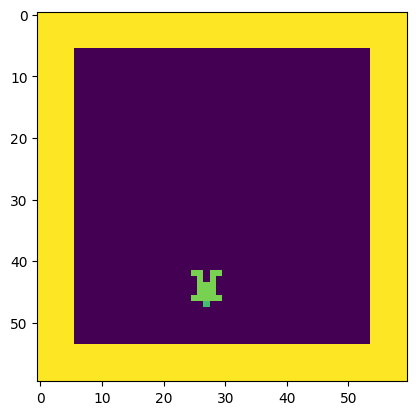

tensor(1, device='cuda:0')


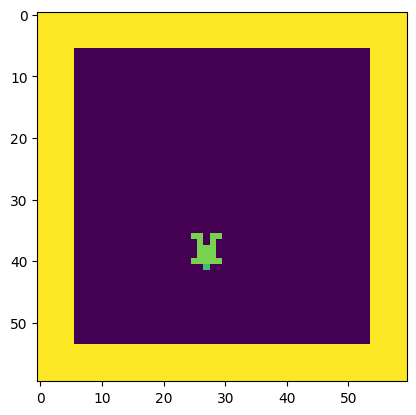

tensor(1, device='cuda:0')


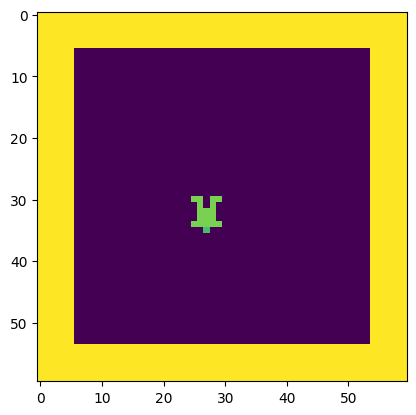

tensor(2, device='cuda:0')


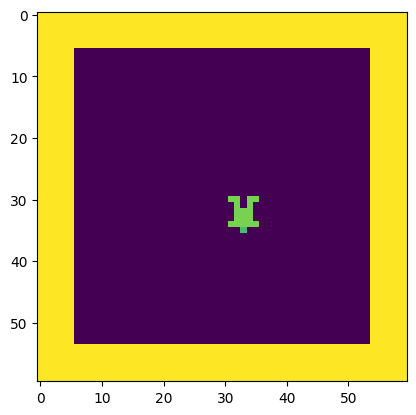

tensor(2, device='cuda:0')


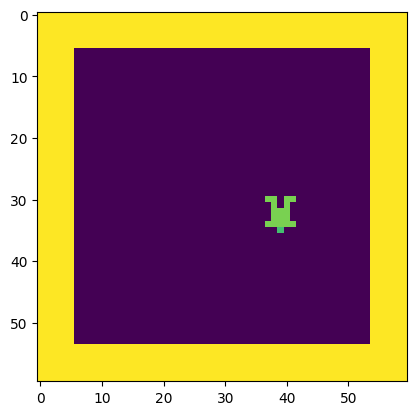

tensor(2, device='cuda:0')


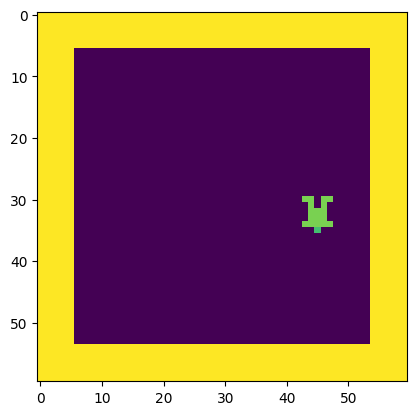

tensor(0, device='cuda:0')


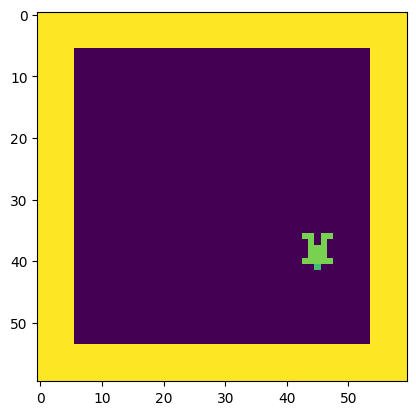

In [10]:
%matplotlib inline

for i in range(100):
    obs = env.observe()
    width = height = int(np.sqrt(obs[0].size))
    _obs = obs[0].reshape((width, height))
    plt.figure()
    plt.imshow(np.flip(_obs.squeeze()))
    plt.show()
    if is_terminal: break
    for i in range(len(obs)):
        agent._state[i][0:-1] = agent._state[i][1:]
        agent._state[i][-1] = obs[i]
    V, action, reward, _ = agent._step()
    print(action)
    agent._Vs_on_last_episode.append(V)
    is_terminal = env.inTerminalState()

### As animation

In [ ]:
%matplotlib notebook

import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

fig, ax = plt.subplots(1,1)
obs = env.observe()
_obs = obs[0].reshape((env.WIDTH, env.HEIGHT))
_obs = np.flip(_obs.squeeze())
ax.set_xticks([])
ax.set_yticks([])
im = ax.imshow(np.zeros(_obs.shape))

def init():
    plt.cla()
    im = ax.imshow(_obs)
    return [im]

def animate(i, *args, **kwargs):
    plt.cla()
    obs = env.observe()
    _obs = obs[0].reshape((env.WIDTH, env.HEIGHT))
    _obs = np.flip(_obs.squeeze())
    im = ax.imshow(_obs)
    for i in range(len(obs)):
        agent._state[i][0:-1] = agent._state[i][1:]
        agent._state[i][-1] = obs[i]
        V, action, reward, _ = agent._step()
        agent._Vs_on_last_episode.append(V)
    return [im]

ani = animation.FuncAnimation(fig, animate, init_func=init, 
     frames=100, blit=False, repeat=True)
ani.save(f'figs/{fname}/behavior.gif', writer="ffmpeg", fps = 15)
fig.show()